# Analysis of Buckeye test set results for AMP Conference
This analyzes model performance on the Buckeye corpus, creating data visuals and statistics for the AMP conference presentation and subsequent papers.

The first section of the notebook reads in prediction data for each model and builds up a pandas DataFrame for analysis.

Note that there is no post-processing to a shared symbol set done here, this evaluates on the IPA output by the model or, in the case of excalibur12/wav2vec2-large-lv60_phoneme-timit_english_timit-4k and excalibur12/wav2vec2-large-lv60_phoneme-timit_english_timit-4k_simplified, the TIMIT symbol set mapped directly to IPA. IPA symbols are normalized to the standard unicode IPA standard whenever possible using `ipatok.tokenise`.

In [1]:
from collections import defaultdict
from pathlib import Path
import regex as re

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

sns.color_palette("colorblind")
font = {"size": 16}
matplotlib.rc("font", **font)
# Remove the limits on the number of rows displayed in the notebook
pd.options.display.max_rows = None



In [2]:
plt.rcParams["figure.figsize"] = (12, 12)
EVAL_PATH = Path("../../data/evaluation_results/detailed_predictions/")
TRAINED_MODEL_PATH = Path("../../data/models/")

GENDER_SPLIT_DURATION_CSV = "gender_split_train_data_durations.csv"

# Results from external baselines
EXTERNAL_PREDICTION_CSVS = [
    EVAL_PATH / "allosaurus_eng2102_eng_detailed_predictions.csv",
    EVAL_PATH
    / "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns_detailed_predictions.csv",
    EVAL_PATH / "facebook_wav2vec2-lv-60-espeak-cv-ft_detailed_predictions.csv",
    EVAL_PATH / "facebook_wav2vec2-xlsr-53-espeak-cv-ft_detailed_predictions.csv",
    EVAL_PATH / "openai_whisper-large-v3-turbo_to_epitran_detailed_predictions.csv",
    EVAL_PATH / "openai_whisper-medium.en_to_epitran_detailed_predictions.csv",
    EVAL_PATH / "excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_detailed_predictions.csv",
    EVAL_PATH / "excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_simplified_detailed_predictions.csv"
]
EXTERNAL_NAME_PATTERN = re.compile(r"[\w-\.]+(?=_detailed_predictions.csv)")

# Results from our models fine-tuned on Buckeye
EXPERIMENT_PREDICTION_CSVS = list(
    EVAL_PATH.glob("data_models_*_detailed_predictions.csv")
) + list(EVAL_PATH.glob("ginic_*_detailed_predictions.csv"))
EXPERIMENT_PREDICTION_CSVS = [file for file in EXPERIMENT_PREDICTION_CSVS if "hyperparams" not in str(file)]
# Use to pull the experiment name and number id from the file name
EXP_NAME_PATTERN = re.compile(
    r"(?<=(data_models_)|(ginic_))[\w-]+(?=_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv|_wav2vec2-large-lv60_phoneme-timit_english_timit-4k-buckeye-ipa_detailed_predictions.csv)"
)

EXPERIMENT_GROUP_DESCRIPTIONS = {
    # Models were trained/fine-tuned on 4000 samples unless otherwise noted
    "data_seed": "Buckeye fine-tuned: balanced gender",
    "gender_split_0_female": "Buckeye fine-tuned: only male speakers",
    "gender_split_30_female": "Buckeye fine-tuned: biased male",
    "gender_split_70_female": "Buckeye fine-tuned: biased female",
    "gender_split_100_female": "Buckeye fine-tuned: only female speakers",
    "vary_individuals_young_only": "Buckeye fine-tuned: biased young",
    "vary_individuals_old_only": "Buckeye fine-tuned: biased old",
    "full_dataset_train": "Buckeye fine-tuned on full train split",
}


In [3]:
def get_experiment_label(full_exp_name, pattern):
    """Parse out the experiment label from the file name
    Experiment label are some brief description (\w chars) followed by _ and a single digit

    Args:
        full_exp_name (str): Filename for experiment results, starts with 'data_model_" followed by the experiment label and ends with "_detailed_predictions.csv"

    Returns:
        str: full experiment label
    """
    experiment_id = pattern.search(full_exp_name)
    return experiment_id.group(0)

In [4]:
# Combine all CSVs together and add meaningful experiment labels
exp_group_display_key = "Experiment group"

all_dataframes = []
for csv in EXPERIMENT_PREDICTION_CSVS:
    print(csv.name)
    dataframe = pd.read_csv(csv, index_col=False)
    experiment_label = get_experiment_label(csv.name, EXP_NAME_PATTERN)
    experiment_group = experiment_label[:-2]
    experiment_id = experiment_label[-1:]
    dataframe["experiment_label"] = experiment_label
    dataframe["experiment_group"] = experiment_group
    dataframe["experiment_id"] = experiment_id
    print(csv.name, "Label:", experiment_label, "Group:", experiment_group, "Experiment id:", experiment_id)
    if experiment_group.startswith("train_duration"):
        # I named the train duration experiments stupidly
        for count in [20000, 12800, 6400, 3200, 1600, 800, 400, 200, 100]:
            if experiment_group.startswith(f"train_duration_{count}"):
                dataframe[exp_group_display_key] = f"Buckeye fine-tuned using {count} samples"
                break
    elif experiment_group.startswith("fine_tune"):
        dataframe[exp_group_display_key] = "Lee 2025 fine-tuned again on Buckeye"
    else:
        for k, v in EXPERIMENT_GROUP_DESCRIPTIONS.items():
            if experiment_group.startswith(k):
                dataframe[exp_group_display_key] = v
                break

    dataframe["Model source"] = "Buckeye fine-tuned"
    all_dataframes.append(dataframe)


for csv in EXTERNAL_PREDICTION_CSVS:
    dataframe = pd.read_csv(csv, index_col=False)
    experiment_label = get_experiment_label(csv.name, EXTERNAL_NAME_PATTERN)
    experiment_group = experiment_label
    experiment_id = 1
    print(csv.name, "Label:", experiment_label, "Group:", experiment_group, "Experiment id:", experiment_id)
    dataframe["experiment_label"] = experiment_label
    dataframe["experiment_group"] = experiment_group
    dataframe["experiment_id"] = experiment_id
    if experiment_label.startswith("allosaurus"):
        dataframe[exp_group_display_key] = "Allosaurus English"
        dataframe["Model source"] = "Allosaurus English"
    elif experiment_label.startswith("ctaguchi"):
        dataframe[exp_group_display_key] = "Taguchi et al. 2023"
        dataframe["Model source"] = "Taguchi et al. 2023"
    elif "whisper" in experiment_label:
        dataframe[exp_group_display_key] = "Whisper + Epitran"
        dataframe["Model source"] = "Whisper + Epitran"
    elif "excalibur12_wav2vec2" in experiment_label:
        dataframe[exp_group_display_key] = "Lee 2025 Wav2Vec2.0 TIMIT fine-tuned"
        dataframe["Model source"] = "Lee 2025 Wav2Vec2.0 TIMIT fine-tuned"
    elif experiment_label.startswith("facebook_wav2vec2"):
        dataframe[exp_group_display_key] = "Wav2Vec2.0 + Espeak"
        dataframe["Model source"] = "Wav2Vec2.0 + Espeak"
    else:
        raise ValueError(f"Unknown experiment label: {experiment_label}")


    all_dataframes.append(dataframe)

all_data = pd.concat(all_dataframes)
all_data.head()



data_models_gender_split_0_female_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
data_models_gender_split_0_female_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv Label: gender_split_0_female_2 Group: gender_split_0_female Experiment id: 2
data_models_train_duration_100_samples_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
data_models_train_duration_100_samples_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv Label: train_duration_100_samples_5 Group: train_duration_100_samples Experiment id: 5
data_models_gender_split_100_female_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
data_models_gender_split_100_female_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv Label: gender_split_100_female_1 Group: gender_split_100_female Experiment id: 1
data_models_train_duration_800_samples_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
data_models_train_duration_800_samples_5_wav2vec2-large-xlsr-53-

,utterance_id,duration,buckeye_transcript,text,ipa,speaker_id,speaker_gender,speaker_age_range,interviewer_gender,file_path,...,phone_feature_error_rates,feature_error_rates,deletions,insertions,substitutions,experiment_label,experiment_group,experiment_id,Experiment group,Model source
0,s2501a_Utt0,0.925981,f ao r f ay v,four five,fɔɹfaɪv,S25,f,o,m,data/buckeye/test/s2501a_Utt0.wav,...,7.0,0.0,"{'f': 2, 'ɔ': 1, 'ɹ': 1, 'a': 1, 'ɪ': 1, 'v': 1}",{},{},gender_split_0_female_2,gender_split_0_female,2,Buckeye fine-tuned: only male speakers,Buckeye fine-tuned
1,s2501a_Utt1,13.394466,U uw ah nx ay hh ey tq hh iy r ih n m ay s eh ...,EXCLUDE-four_five_six_seven_eight_nine_ten_ele...,uʌɾ̃aɪheɪʔhiɹɪnmaɪsɛlfɑn,S25,f,o,m,data/buckeye/test/s2501a_Utt1.wav,...,23.0,0.0,"{'u': 1, 'ʌ': 1, 'ɾ̃': 1, 'a': 2, 'ɪ': 4, 'h':...",{},{},gender_split_0_female_2,gender_split_0_female,2,Buckeye fine-tuned: only male speakers,Buckeye fine-tuned
2,s2501a_Utt2,22.609051,ah k ey U ah m ay tq w aa n n ah ch r ay dx uh...,okay VOCNOISE i might want to try to adjust th...,ʌkeɪʌmaɪʔwɑnnʌtʃɹaɪɾʊɪdʒʌssɪsʌlɪɾl̩bɪɾɪɡɛnɪfjʌ...,S25,f,o,m,data/buckeye/test/s2501a_Utt2.wav,...,76.0,0.0,"{'ʌ': 8, 'k': 1, 'e': 2, 'ɪ': 14, 'm': 2, 'a':...",{},{},gender_split_0_female_2,gender_split_0_female,2,Buckeye fine-tuned: only male speakers,Buckeye fine-tuned
3,s2501a_Utt3,2.279839,n aa t U ih tq ah z b eh dx er b ih f ao r,not LAUGH it was better before,nɑtɪʔʌzbɛɾɹ̩bɪfɔɹ,S25,f,o,m,data/buckeye/test/s2501a_Utt3.wav,...,16.0,0.0,"{'n': 1, 'ɑ': 1, 't': 1, 'ɪ': 2, 'ʔ': 1, 'ʌ': ...",{},{},gender_split_0_female_2,gender_split_0_female,2,Buckeye fine-tuned: only male speakers,Buckeye fine-tuned
4,s2501a_Utt4,0.410576,dh eh r,there,ðɛɹ,S25,f,o,m,data/buckeye/test/s2501a_Utt4.wav,...,3.0,0.0,"{'ð': 1, 'ɛ': 1, 'ɹ': 1}",{},{},gender_split_0_female_2,gender_split_0_female,2,Buckeye fine-tuned: only male speakers,Buckeye fine-tuned


# Overall model performance in aggregate
This section collects the test set performance results form all models to compare. 

The metrics we are using to measure model performance are described as follows and lower values indicate better performance for all of them: 
- **phone error rate**: Phone error rate (PER) gives edit distance in terms of phones for each prediction-reference pair, rather than Unicode characters, since phones can consist of multiple characters. It is normalized by the number of phones of the reference string. The result will have the same length as the input prediction and reference lists.
- **phone feature error rate**: Phone feature error rate (PFER) is Levenshtein distance between strings where distance between individual phones is computed using Hamming distance between phonetic features for each prediction-reference pair. By default it is a metric that obeys the triangle equality, but can also be normalized by number of phones.
- **feature error rate**: Feature error rate (FER) is the edit distance in terms of articulatory features normalized by the number of phones in the reference, computed for each prediction-reference pair.

## Summary of results
- All the models (except some trained on a very small amount of data or only using fine-tuning data from male or female speakers) we've trained on Buckeye data perform better than external baselines on the Buckey test set, which include the [best model](https://huggingface.co/ctaguchi/wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns) from the [Taguchi paper](http://arxiv.org/pdf/2308.03917), [Allosaurus](https://github.com/xinjli/allosaurus), and passing wav2vec2/Whisper output to the [Epitran](https://github.com/dmort27/epitran) grapheme to phoneme library. This is fairly unsurprising, given that we've fine-tuned our models on data that is more similar to the test set. However, it does demonstrate the benefit of fine-tuning in situations where low error rates are critically important. 

In [5]:
# Overall average error rates for each individual model
by_model_avg_metrics = (
    all_data.groupby(
        [
            "experiment_label", "experiment_group", exp_group_display_key, "Model source" #last 3 keys are added just so we don't have to join them in later
        ]
    )[["phone_error_rates", "phone_feature_error_rates", "feature_error_rates"]]
    .mean()
    .reset_index()
    .sort_values(by="phone_error_rates")
)
display(by_model_avg_metrics.head(10))

,experiment_label,experiment_group,Experiment group,Model source,phone_error_rates,phone_feature_error_rates,feature_error_rates
65,train_duration_20000_samples_4,train_duration_20000_samples,Buckeye fine-tuned using 20000 samples,Buckeye fine-tuned,0.252720,3.869372,0.158717
64,train_duration_20000_samples_3,train_duration_20000_samples,Buckeye fine-tuned using 20000 samples,Buckeye fine-tuned,0.253557,3.846254,0.159487
52,train_duration_12800_samples_1,train_duration_12800_samples,Buckeye fine-tuned using 12800 samples,Buckeye fine-tuned,0.254866,3.903163,0.158030
24,full_dataset_train_5,full_dataset_train,Buckeye fine-tuned on full train split,Buckeye fine-tuned,0.256308,3.902466,0.157821
20,full_dataset_train_1,full_dataset_train,Buckeye fine-tuned on full train split,Buckeye fine-tuned,0.257255,3.838879,0.158893
55,train_duration_12800_samples_4,train_duration_12800_samples,Buckeye fine-tuned using 12800 samples,Buckeye fine-tuned,0.257684,3.936552,0.158598
54,train_duration_12800_samples_3,train_duration_12800_samples,Buckeye fine-tuned using 12800 samples,Buckeye fine-tuned,0.257969,3.884516,0.158563
56,train_duration_12800_samples_5,train_duration_12800_samples,Buckeye fine-tuned using 12800 samples,Buckeye fine-tuned,0.258357,3.921212,0.159332
23,full_dataset_train_4,full_dataset_train,Buckeye fine-tuned on full train split,Buckeye fine-tuned,0.258789,3.935839,0.158900
62,train_duration_20000_samples_1,train_duration_20000_samples,Buckeye fine-tuned using 20000 samples,Buckeye fine-tuned,0.259358,3.977391,0.159365


In [6]:
# Limit to only the best performing model in each group
best_experiment_in_group = (
    by_model_avg_metrics.groupby([exp_group_display_key, "Model source"])[
        ["experiment_label", "phone_error_rates", "phone_feature_error_rates", "feature_error_rates"]
    ]
    .first()
    .reset_index()
    .sort_values(by="phone_error_rates")
)

display(best_experiment_in_group)

,Experiment group,Model source,experiment_label,phone_error_rates,phone_feature_error_rates,feature_error_rates
6,Buckeye fine-tuned using 20000 samples,Buckeye fine-tuned,train_duration_20000_samples_4,0.252720,3.869372,0.158717
3,Buckeye fine-tuned using 12800 samples,Buckeye fine-tuned,train_duration_12800_samples_1,0.254866,3.903163,0.158030
1,Buckeye fine-tuned on full train split,Buckeye fine-tuned,full_dataset_train_5,0.256308,3.902466,0.157821
9,Buckeye fine-tuned using 6400 samples,Buckeye fine-tuned,train_duration_6400_samples_2,0.262291,3.984864,0.160182
19,Lee 2025 fine-tuned again on Buckeye,Buckeye fine-tuned,fine_tune_data_seed_bs32_3,0.267155,3.855853,0.155955
12,Buckeye fine-tuned: biased female,Buckeye fine-tuned,gender_split_70_female_2,0.276478,4.231386,0.164055
11,Buckeye fine-tuned: balanced gender,Buckeye fine-tuned,data_seed_bs64_1,0.279805,4.259689,0.162166
16,Buckeye fine-tuned: only female speakers,Buckeye fine-tuned,gender_split_100_female_4,0.281617,4.236874,0.161531
13,Buckeye fine-tuned: biased male,Buckeye fine-tuned,gender_split_30_female_4,0.287317,4.390759,0.167159
14,Buckeye fine-tuned: biased old,Buckeye fine-tuned,vary_individuals_old_only_1,0.289996,4.449367,0.166510


In [7]:
model_type_means = (
    all_data.groupby([exp_group_display_key, "Model source"])[
        ["phone_error_rates", "phone_feature_error_rates", "feature_error_rates"]
    ]
    .mean()
    .reset_index()
    .sort_values(by="phone_error_rates")
)
display(model_type_means)


,Experiment group,Model source,phone_error_rates,phone_feature_error_rates,feature_error_rates
6,Buckeye fine-tuned using 20000 samples,Buckeye fine-tuned,0.258334,3.985757,0.159476
1,Buckeye fine-tuned on full train split,Buckeye fine-tuned,0.259110,3.926513,0.159418
3,Buckeye fine-tuned using 12800 samples,Buckeye fine-tuned,0.259346,3.954382,0.159228
9,Buckeye fine-tuned using 6400 samples,Buckeye fine-tuned,0.264076,4.069735,0.160735
16,Buckeye fine-tuned: only female speakers,Buckeye fine-tuned,0.289422,4.345821,0.161507
11,Buckeye fine-tuned: balanced gender,Buckeye fine-tuned,0.289700,4.370652,0.162465
12,Buckeye fine-tuned: biased female,Buckeye fine-tuned,0.292399,4.402909,0.166525
14,Buckeye fine-tuned: biased old,Buckeye fine-tuned,0.297602,4.465058,0.167044
15,Buckeye fine-tuned: biased young,Buckeye fine-tuned,0.299078,4.449676,0.167108
13,Buckeye fine-tuned: biased male,Buckeye fine-tuned,0.306236,4.517336,0.166410


/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_71697/1690511335.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='right')


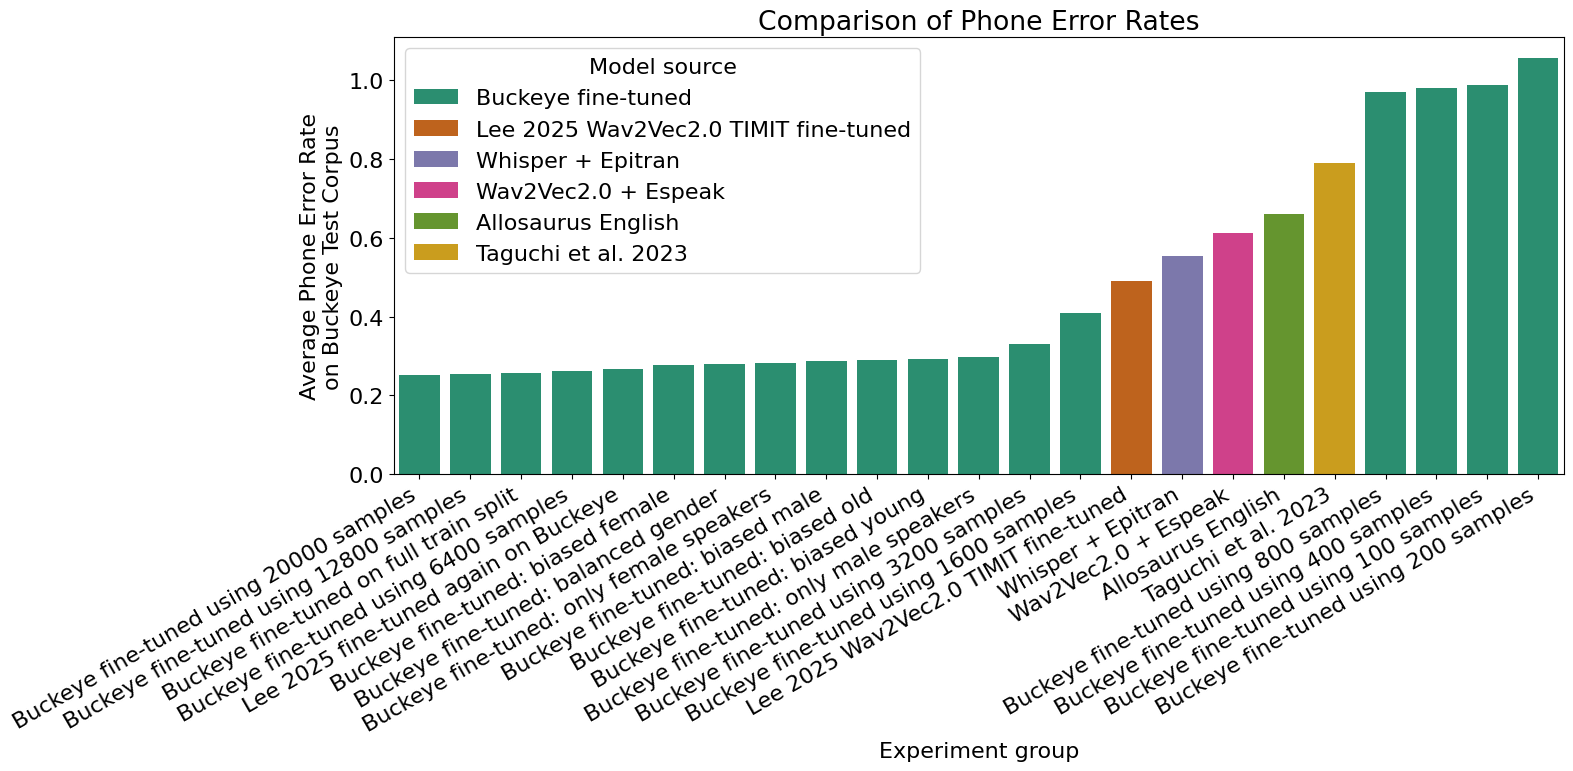

In [8]:
# Compare the average phone error rate for the best model in each group
plt.figure(figsize=(16, 8))
g = sns.barplot(
    data=best_experiment_in_group, x=exp_group_display_key, y="phone_error_rates", hue="Model source", palette="Dark2"
)
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='right')
g.set_title("Comparison of Phone Error Rates")
g.set_ylabel("Average Phone Error Rate\non Buckeye Test Corpus")
plt.tight_layout()


/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_71697/402440689.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment="right")


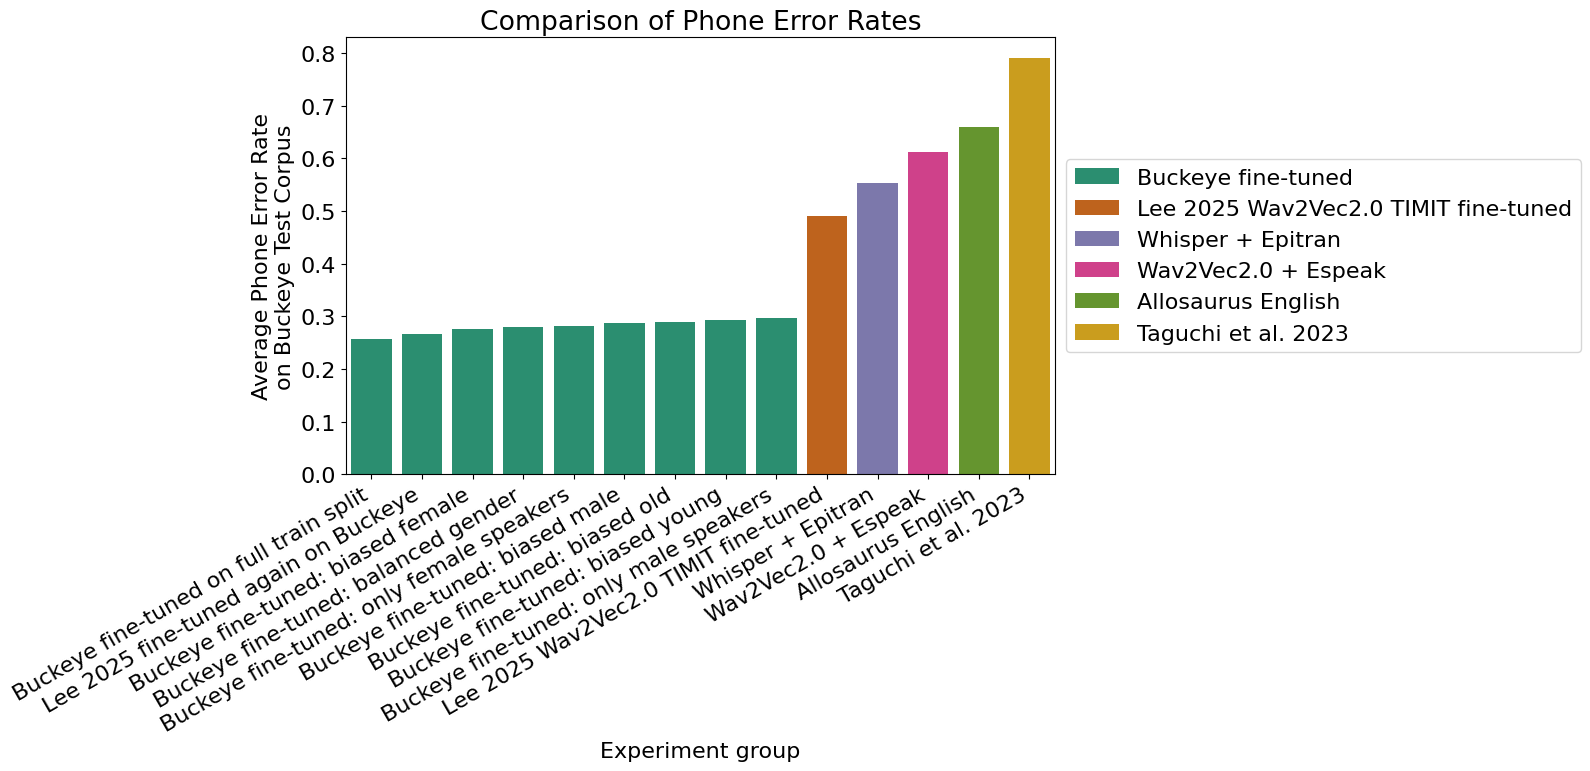

In [9]:
# Compare the average phone error rate for the best model in each group, but exclude 'train duration' experiments
best_models_no_train_duration = best_experiment_in_group[
    ~best_experiment_in_group["experiment_label"].str.startswith("train_duration")
]
plt.figure(figsize=(16, 8))
g = sns.barplot(
    data=best_models_no_train_duration,
    x=exp_group_display_key,
    y="phone_error_rates",
    hue="Model source",
    palette="Dark2",
)
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment="right")
g.set_title("Comparison of Phone Error Rates")
g.set_ylabel("Average Phone Error Rate\non Buckeye Test Corpus")
plt.legend(bbox_to_anchor=(1.0, 0.5), loc="center left")
plt.tight_layout()


/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_71697/1672366235.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment="right")


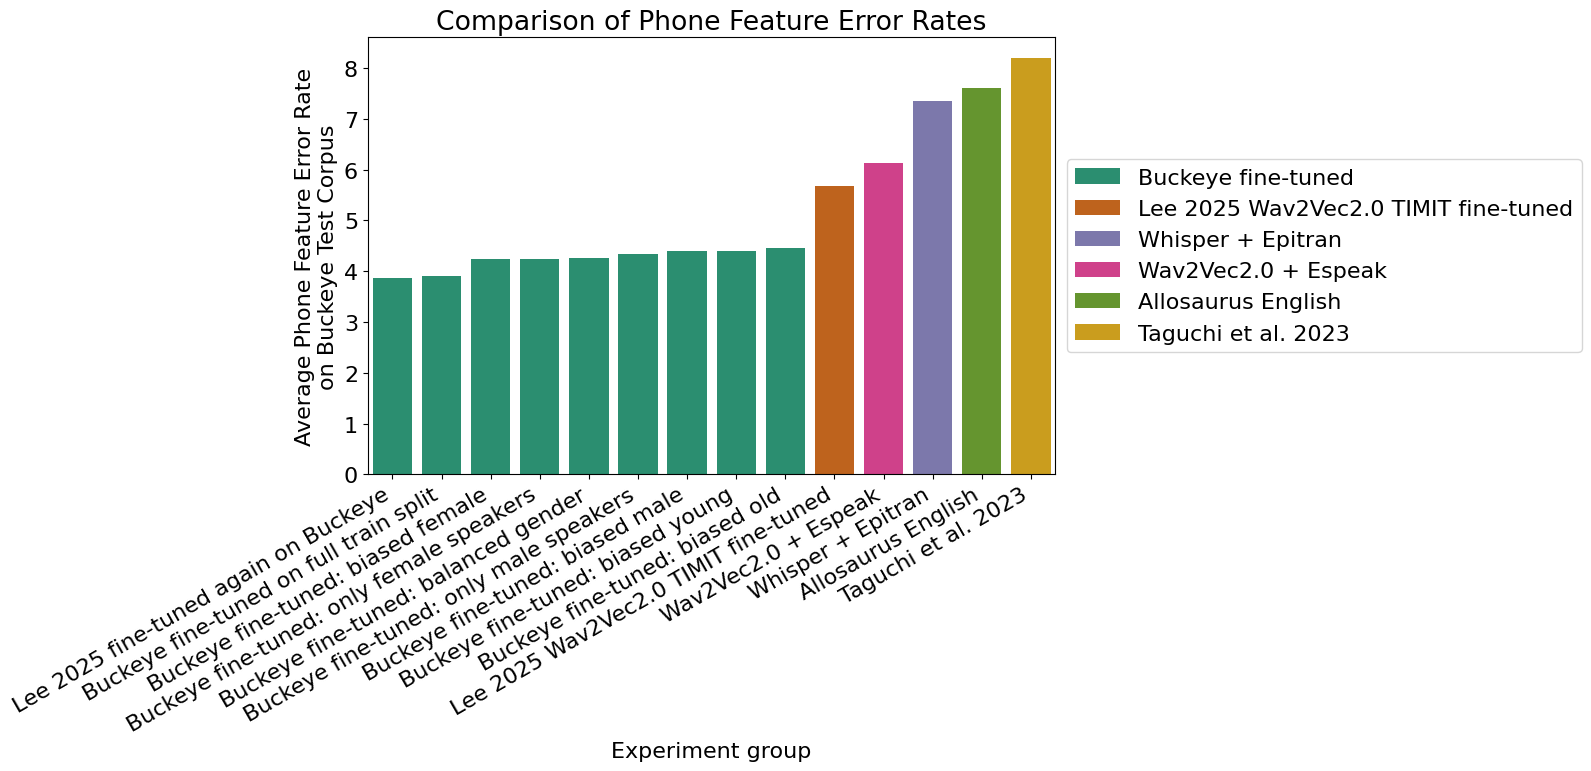

In [10]:
# Compare the average phone feature error rate for the best model in each group, but exclude 'train duration' experiments
best_models_no_train_duration = best_experiment_in_group[
    ~best_experiment_in_group["experiment_label"].str.startswith("train_duration")
]
# Get unique experiment groups sorted by their mean phone_feature_error_rates
ordered_groups = (
    best_models_no_train_duration.groupby(exp_group_display_key)["phone_feature_error_rates"]
    .mean()
    .sort_values()
    .index
)

plt.figure(figsize=(16, 8))
g = sns.barplot(
    data=best_models_no_train_duration,
    x=exp_group_display_key,
    y="phone_feature_error_rates",
    hue="Model source",
    palette="Dark2",
    order=ordered_groups,  # Add this line to sort the bars
)
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment="right")
g.set_title("Comparison of Phone Feature Error Rates")
g.set_ylabel("Average Phone Feature Error Rate\non Buckeye Test Corpus")
plt.legend(bbox_to_anchor=(1.0, 0.5), loc="center left")
plt.tight_layout()


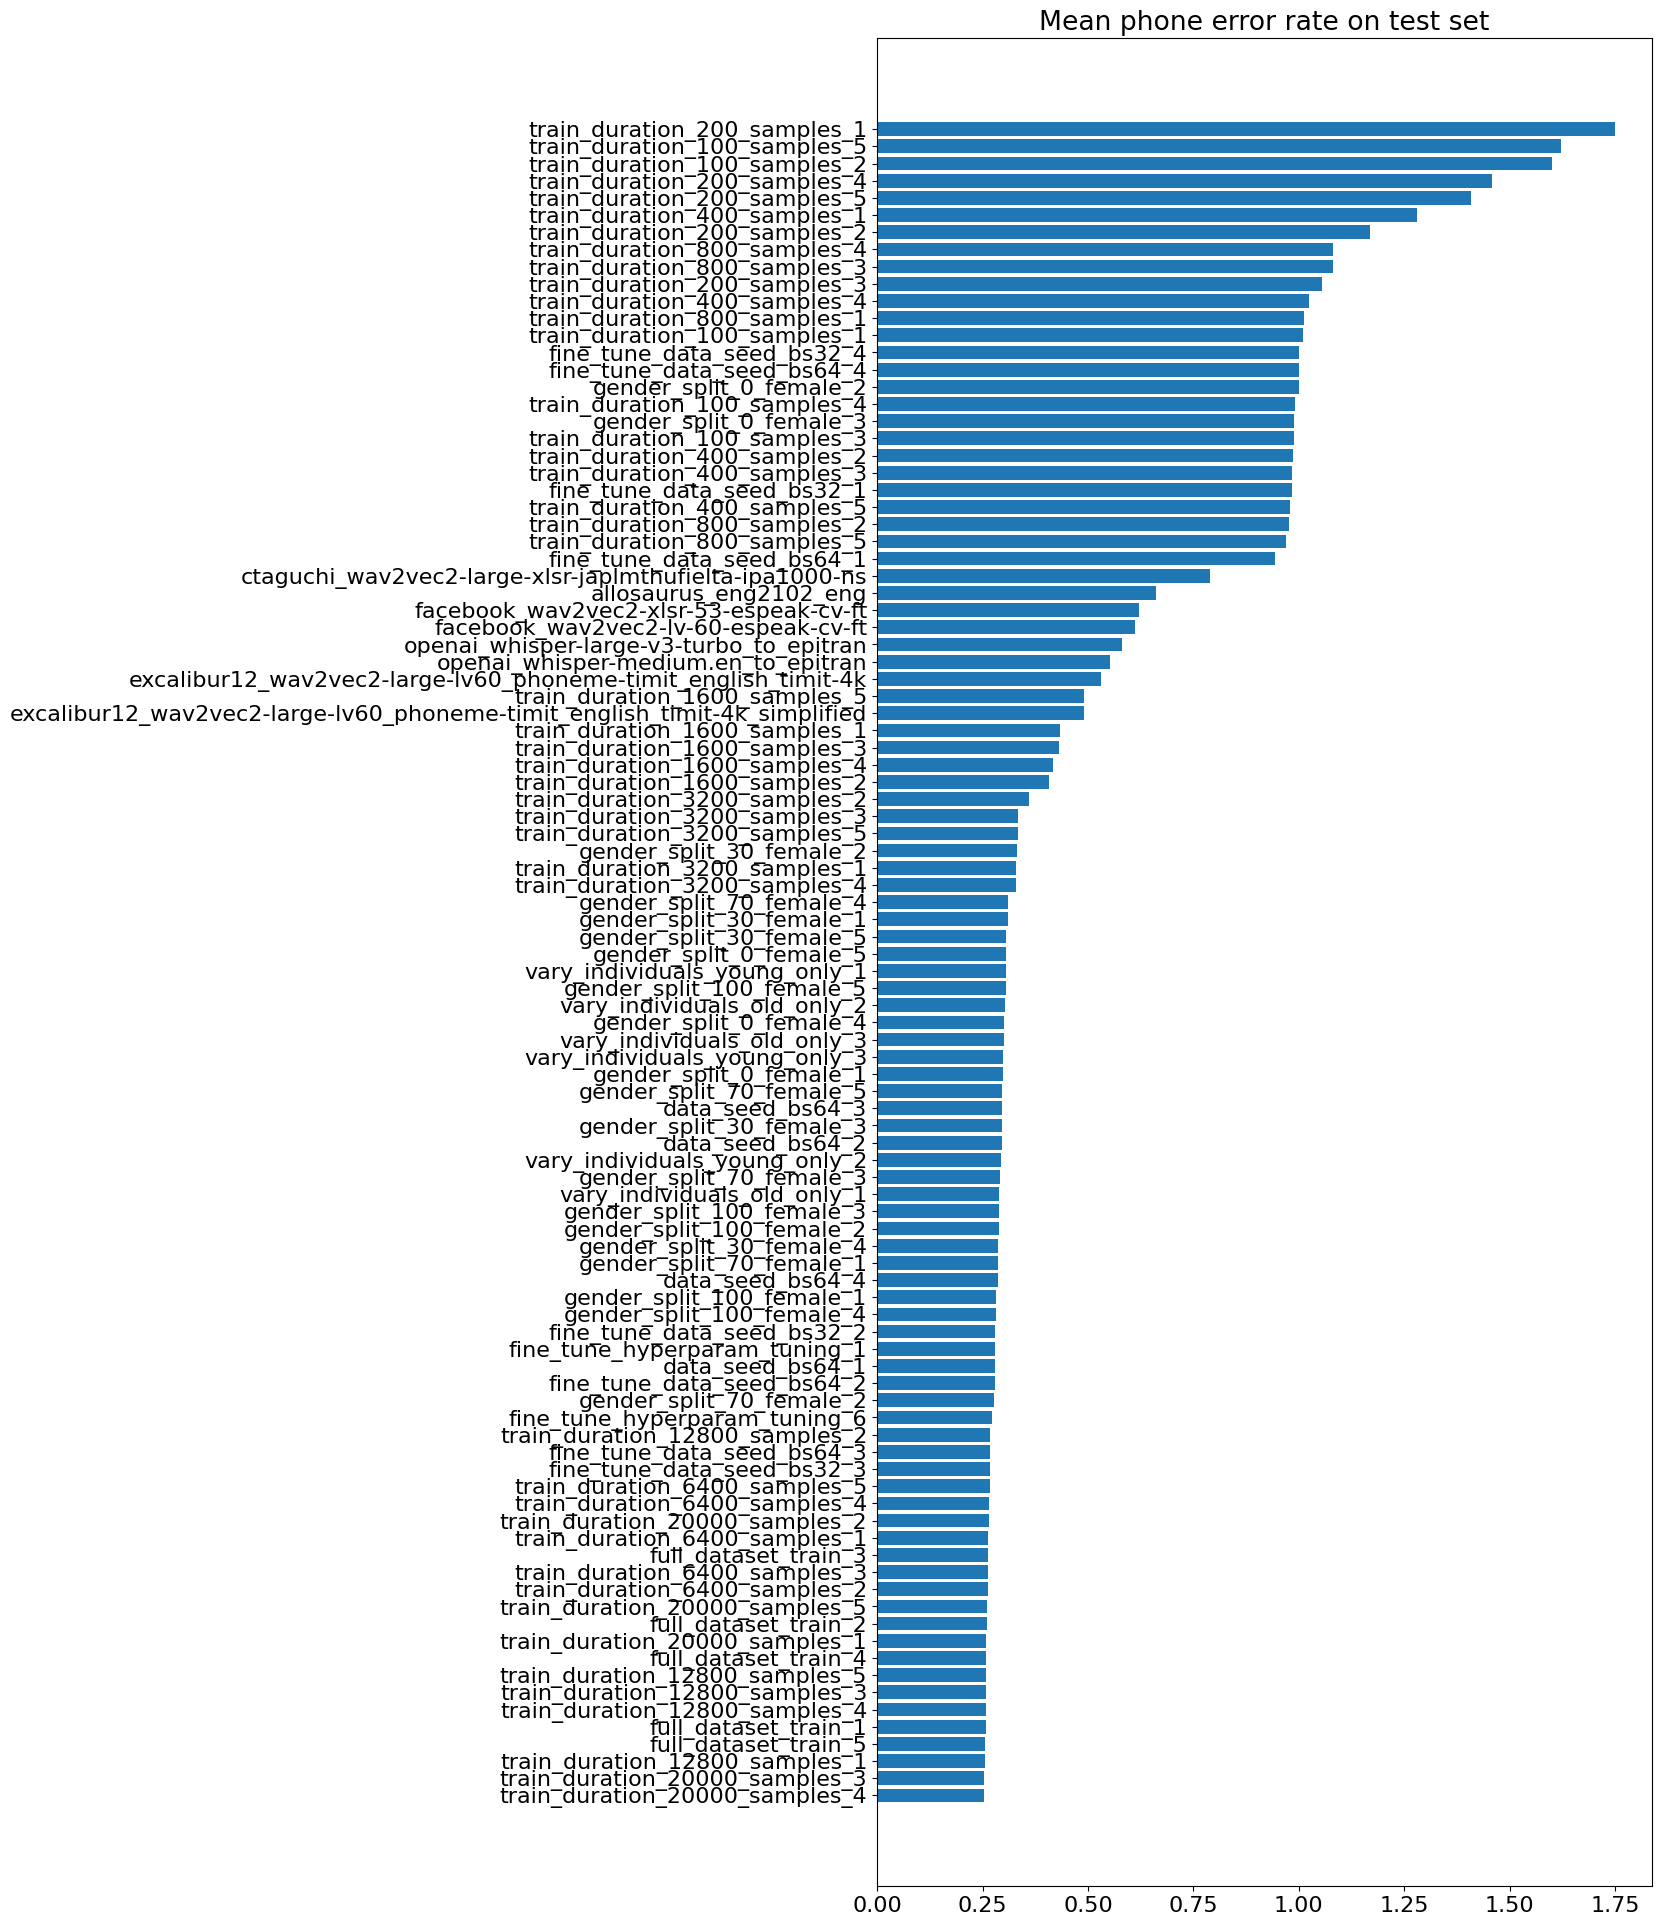

In [11]:
# Average phone error rate on test set samples for each model we trained
fig, ax = plt.subplots(figsize=(10, 24)) # Change the height here
temp_df = by_model_avg_metrics.sort_values(by="phone_error_rates")
ax.barh(temp_df["experiment_label"], temp_df["phone_error_rates"])
_ = ax.set_title("Mean phone error rate on test set")

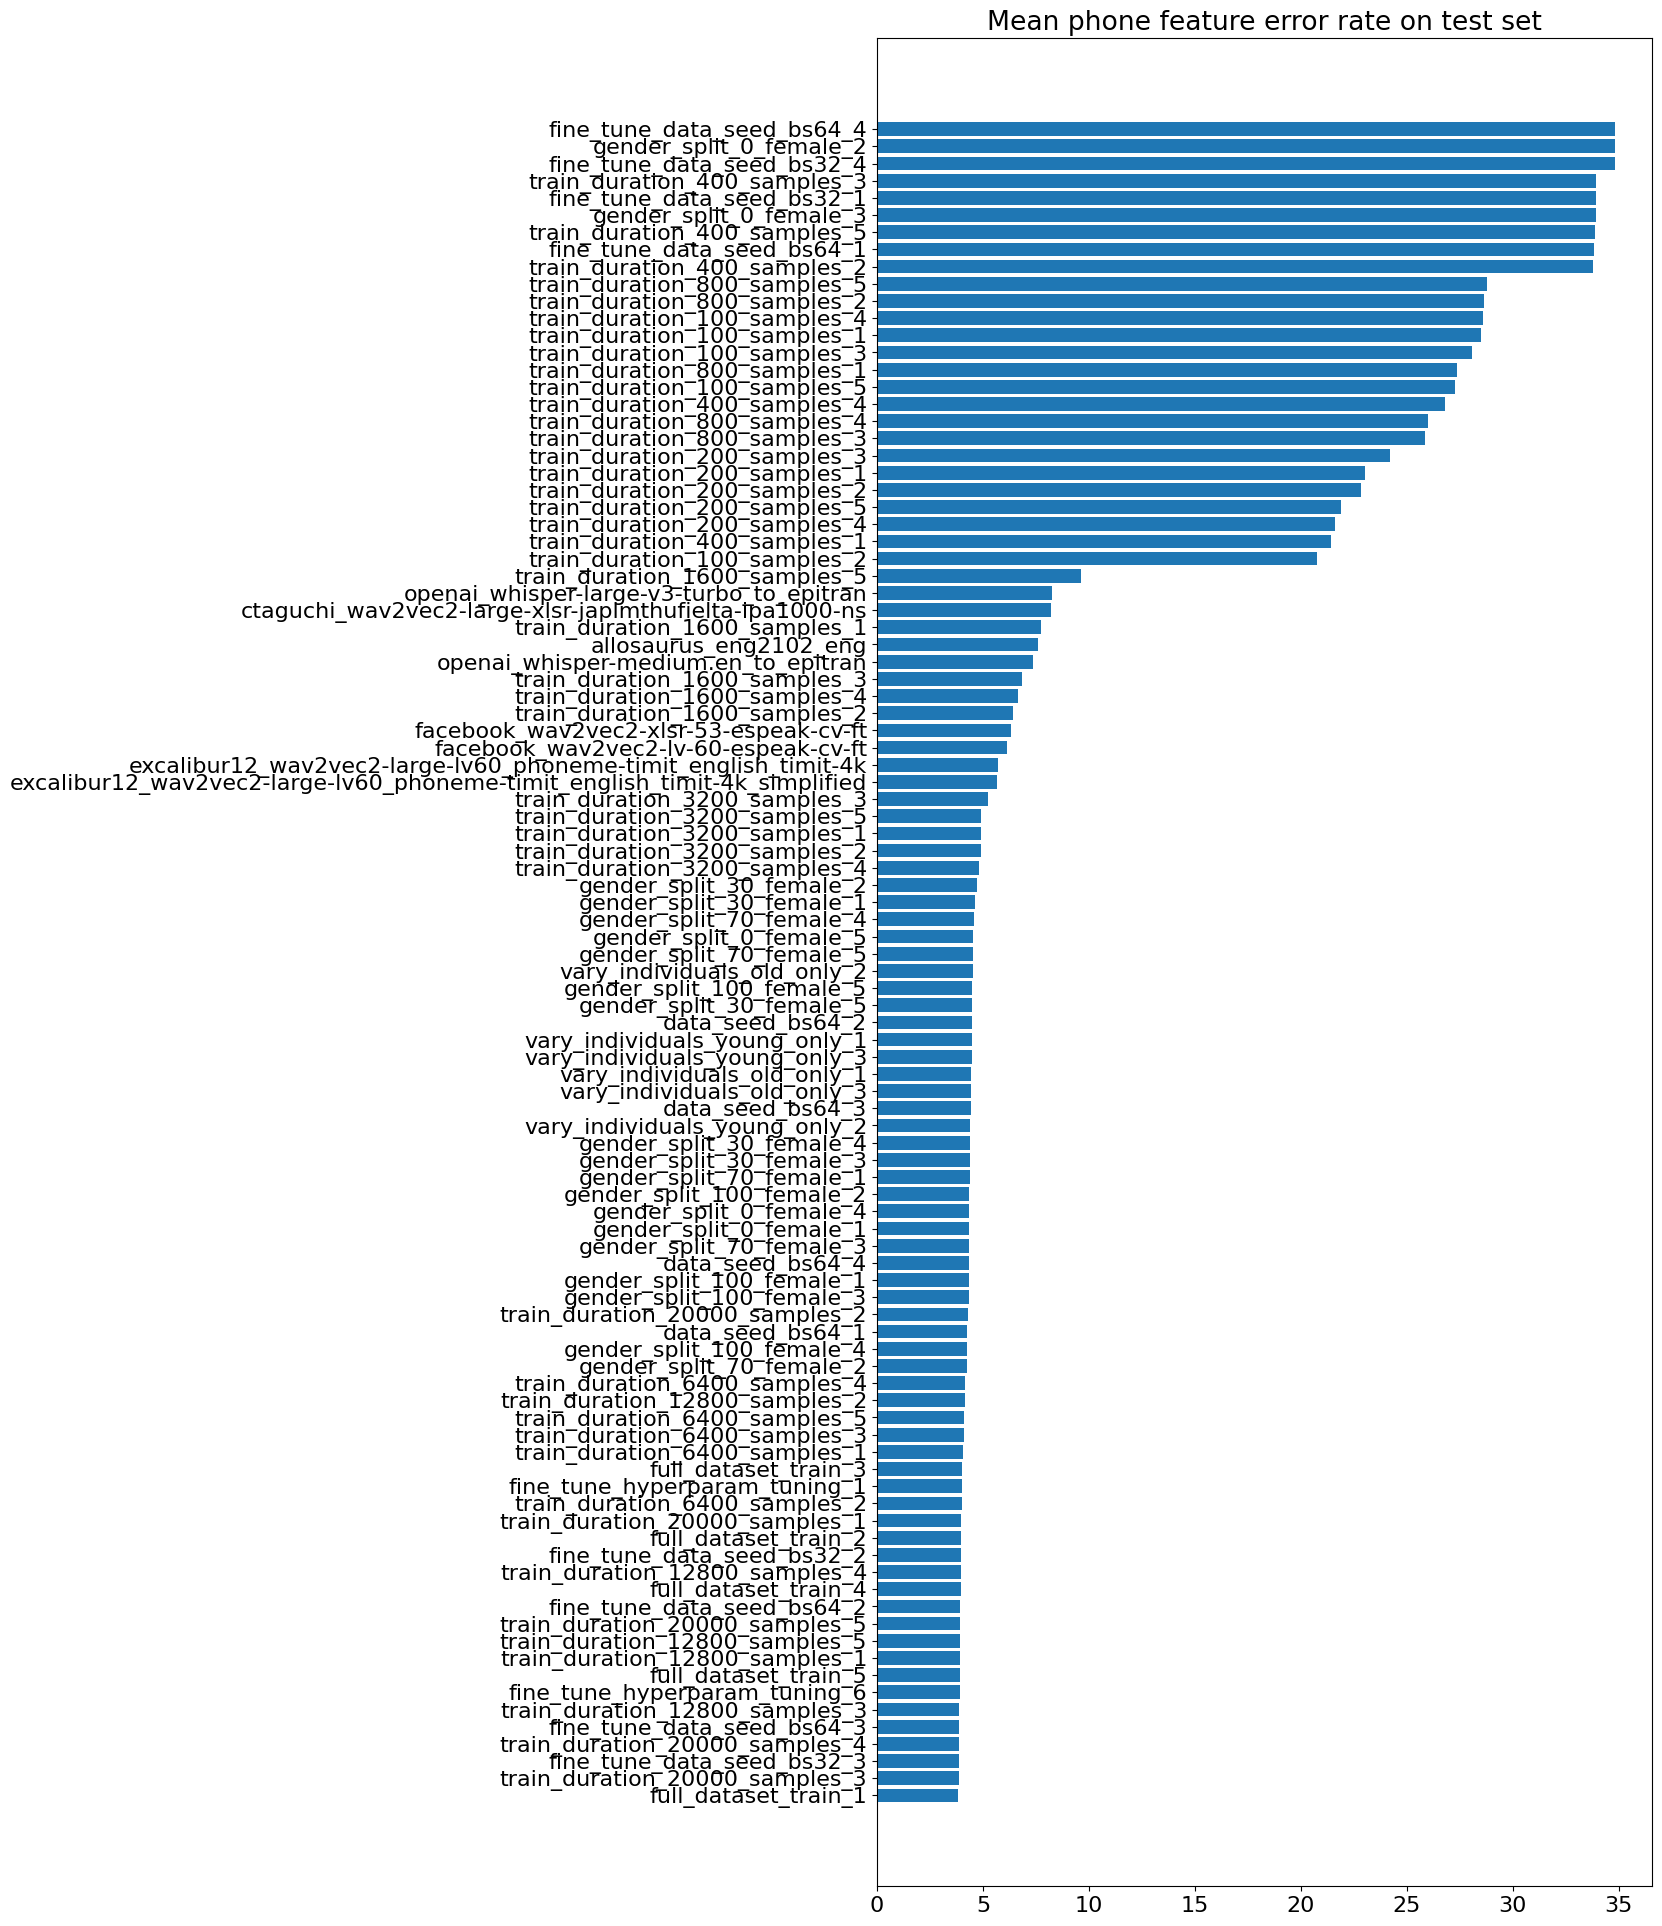

In [12]:

# Average phone error rate on test set samples for each model we trained
by_model_avg_metrics.sort_values(by="phone_feature_error_rates", inplace=True)
fig, ax = plt.subplots(figsize=(10, 24))
ax.barh(by_model_avg_metrics["experiment_label"], by_model_avg_metrics["phone_feature_error_rates"])
_ = ax.set_title("Mean phone feature error rate on test set")

# Differences in performance by gender
This looks at the differences in performance in models trained on different shares of samples from male and female speakers. 
Across the board, the models (both our fine-tuned and the external baselines) perform better on female speakers than male speakers. This is not due to the duration of speakers of a specific gender appearing in the training data, because performance metrics are higher for female speakers even when 70% of training data samples came from male speakers and the duration of training data from male speakers was larger than the duration of training samples from female speakers. 

Note that it is yet unclear whether these performance differences are statistically significance. That requires further discussion of experimental design and desired research goals. 

In [13]:
# I want only these groups and in a very specific order for display
gender_analysis_groups = [
    "full_dataset_train",
    "data_seed_bs64",
    "gender_split_0_female",
    "gender_split_30_female",
    "gender_split_70_female",
    "gender_split_100_female",
    "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns",
    "excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k",
    "facebook_wav2vec2-lv-60-espeak-cv-ft",
    "openai_whisper-large-v3-turbo_to_epitran",
    "openai_whisper-medium.en_to_epitran",
]

gender_analysis_predictions_df = all_data[
    all_data["experiment_group"].isin(gender_analysis_groups)
]

print(gender_analysis_predictions_df.shape)
display(gender_analysis_predictions_df.head())

(172686, 22)


,utterance_id,duration,buckeye_transcript,text,ipa,speaker_id,speaker_gender,speaker_age_range,interviewer_gender,file_path,...,phone_feature_error_rates,feature_error_rates,deletions,insertions,substitutions,experiment_label,experiment_group,experiment_id,Experiment group,Model source
0,s2501a_Utt0,0.925981,f ao r f ay v,four five,fɔɹfaɪv,S25,f,o,m,data/buckeye/test/s2501a_Utt0.wav,...,7.0,0.0,"{'f': 2, 'ɔ': 1, 'ɹ': 1, 'a': 1, 'ɪ': 1, 'v': 1}",{},{},gender_split_0_female_2,gender_split_0_female,2,Buckeye fine-tuned: only male speakers,Buckeye fine-tuned
1,s2501a_Utt1,13.394466,U uw ah nx ay hh ey tq hh iy r ih n m ay s eh ...,EXCLUDE-four_five_six_seven_eight_nine_ten_ele...,uʌɾ̃aɪheɪʔhiɹɪnmaɪsɛlfɑn,S25,f,o,m,data/buckeye/test/s2501a_Utt1.wav,...,23.0,0.0,"{'u': 1, 'ʌ': 1, 'ɾ̃': 1, 'a': 2, 'ɪ': 4, 'h':...",{},{},gender_split_0_female_2,gender_split_0_female,2,Buckeye fine-tuned: only male speakers,Buckeye fine-tuned
2,s2501a_Utt2,22.609051,ah k ey U ah m ay tq w aa n n ah ch r ay dx uh...,okay VOCNOISE i might want to try to adjust th...,ʌkeɪʌmaɪʔwɑnnʌtʃɹaɪɾʊɪdʒʌssɪsʌlɪɾl̩bɪɾɪɡɛnɪfjʌ...,S25,f,o,m,data/buckeye/test/s2501a_Utt2.wav,...,76.0,0.0,"{'ʌ': 8, 'k': 1, 'e': 2, 'ɪ': 14, 'm': 2, 'a':...",{},{},gender_split_0_female_2,gender_split_0_female,2,Buckeye fine-tuned: only male speakers,Buckeye fine-tuned
3,s2501a_Utt3,2.279839,n aa t U ih tq ah z b eh dx er b ih f ao r,not LAUGH it was better before,nɑtɪʔʌzbɛɾɹ̩bɪfɔɹ,S25,f,o,m,data/buckeye/test/s2501a_Utt3.wav,...,16.0,0.0,"{'n': 1, 'ɑ': 1, 't': 1, 'ɪ': 2, 'ʔ': 1, 'ʌ': ...",{},{},gender_split_0_female_2,gender_split_0_female,2,Buckeye fine-tuned: only male speakers,Buckeye fine-tuned
4,s2501a_Utt4,0.410576,dh eh r,there,ðɛɹ,S25,f,o,m,data/buckeye/test/s2501a_Utt4.wav,...,3.0,0.0,"{'ð': 1, 'ɛ': 1, 'ɹ': 1}",{},{},gender_split_0_female_2,gender_split_0_female,2,Buckeye fine-tuned: only male speakers,Buckeye fine-tuned


In [14]:
def mean_grouped_by_experiment_group_and_demographic(
    dataframe, experiment_label_key="experiment_label", experiment_group_key="experiment_group", demo_key="speaker_gender"
):
    grouped_data = dataframe.groupby([experiment_label_key, experiment_group_key, demo_key]).agg(
        {"phone_error_rates": "mean", "phone_feature_error_rates": "mean", "feature_error_rates": "mean"}
    )
    grouped_dataframe = grouped_data.reset_index()
    grouped_dataframe.experiment_group = grouped_dataframe.experiment_group.astype("category")
    grouped_dataframe.experiment_group.cat.set_categories(gender_analysis_groups)
    return grouped_dataframe.sort_values(by=["experiment_group"])

In [15]:
mean_perf_by_gender_df = mean_grouped_by_experiment_group_and_demographic(gender_analysis_predictions_df)
display(mean_perf_by_gender_df.head())

,experiment_label,experiment_group,speaker_gender,phone_error_rates,phone_feature_error_rates,feature_error_rates
0,ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ip...,ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ip...,f,0.770575,7.118656,0.241856
1,ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ip...,ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ip...,m,0.815507,9.566536,0.258792
2,data_seed_bs64_1,data_seed_bs64,f,0.252728,3.315225,0.147093
3,data_seed_bs64_1,data_seed_bs64,m,0.314260,5.461503,0.181347
4,data_seed_bs64_2,data_seed_bs64,f,0.262229,3.519852,0.148487


Text(0.5, 1.0, 'Average Phone Error Rates by Gender')

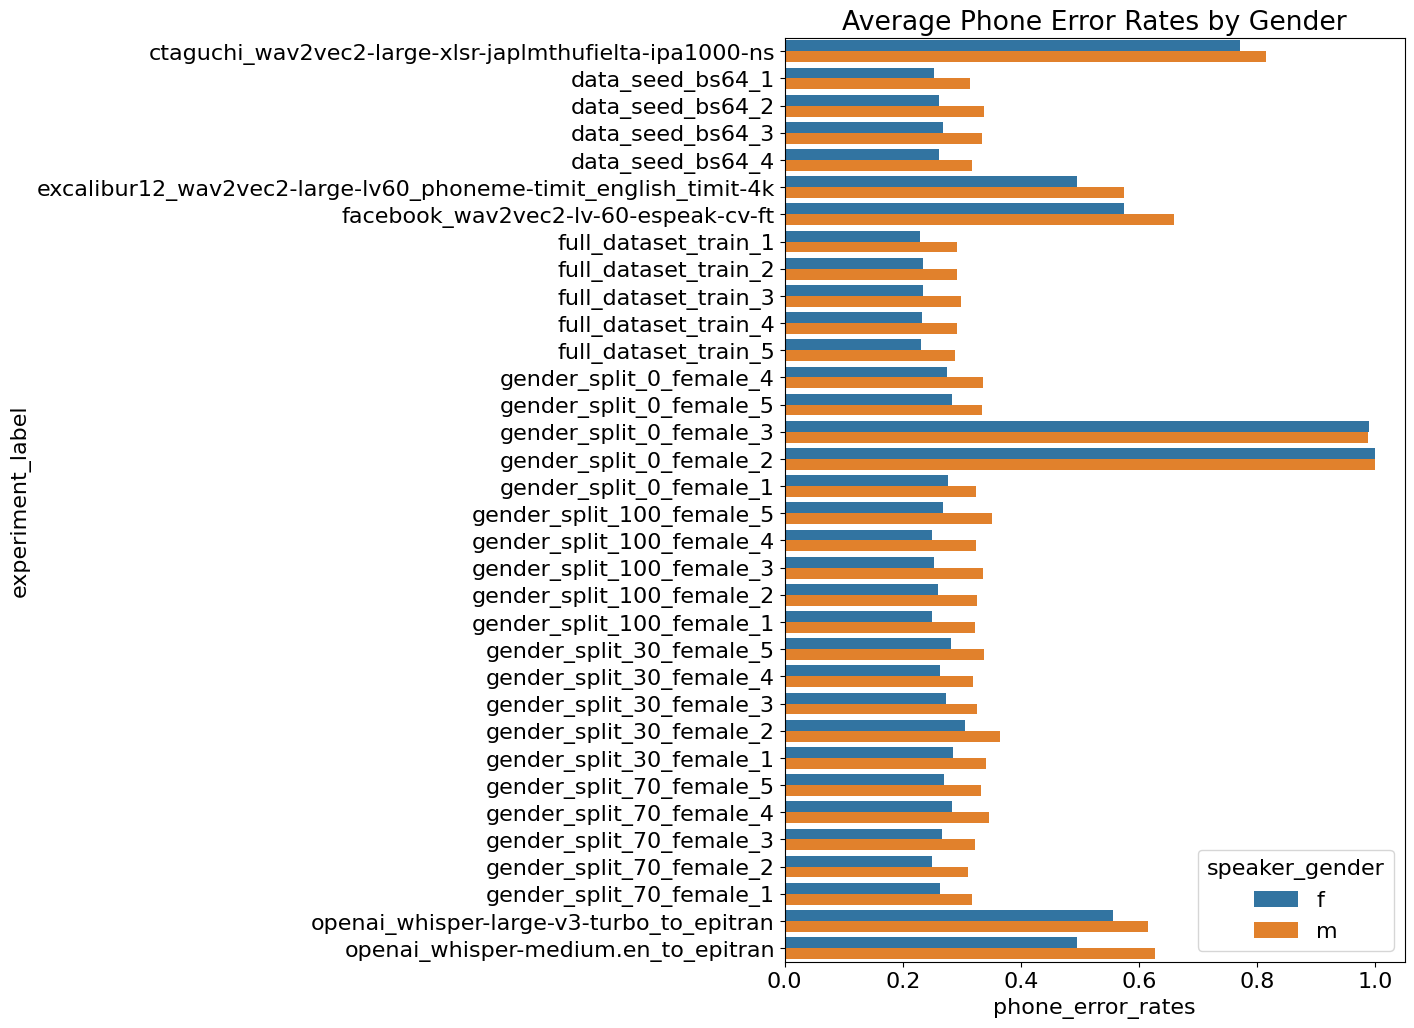

In [16]:
plt.figure(figsize=(8, 12))
g = sns.barplot(mean_perf_by_gender_df, y="experiment_label", x="phone_error_rates", hue="speaker_gender")
g.set_title("Average Phone Error Rates by Gender")

In [17]:
# Gender analysis only for the best model in each group to use for presentation
best_model_gender_df = pd.merge(mean_perf_by_gender_df, best_experiment_in_group[["Experiment group", "Model source", "experiment_label"]], on=["experiment_label"], how="inner").sort_values(by="Experiment group")
best_model_gender_df = best_model_gender_df.sort_values(by=["experiment_group"])
display(best_model_gender_df)

,experiment_label,experiment_group,speaker_gender,phone_error_rates,phone_feature_error_rates,feature_error_rates,Experiment group,Model source
1,ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ip...,ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ip...,m,0.815507,9.566536,0.258792,Taguchi et al. 2023,Taguchi et al. 2023
0,ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ip...,ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ip...,f,0.770575,7.118656,0.241856,Taguchi et al. 2023,Taguchi et al. 2023
2,data_seed_bs64_1,data_seed_bs64,f,0.252728,3.315225,0.147093,Buckeye fine-tuned: balanced gender,Buckeye fine-tuned
3,data_seed_bs64_1,data_seed_bs64,m,0.314260,5.461503,0.181347,Buckeye fine-tuned: balanced gender,Buckeye fine-tuned
4,facebook_wav2vec2-lv-60-espeak-cv-ft,facebook_wav2vec2-lv-60-espeak-cv-ft,m,0.659525,7.325746,0.238775,Wav2Vec2.0 + Espeak,Wav2Vec2.0 + Espeak
5,facebook_wav2vec2-lv-60-espeak-cv-ft,facebook_wav2vec2-lv-60-espeak-cv-ft,f,0.575280,5.178929,0.224301,Wav2Vec2.0 + Espeak,Wav2Vec2.0 + Espeak
6,full_dataset_train_5,full_dataset_train,f,0.230671,3.052186,0.141670,Buckeye fine-tuned on full train split,Buckeye fine-tuned
7,full_dataset_train_5,full_dataset_train,m,0.288929,4.984433,0.178373,Buckeye fine-tuned on full train split,Buckeye fine-tuned
9,gender_split_0_female_1,gender_split_0_female,m,0.323480,5.420227,0.186401,Buckeye fine-tuned: only male speakers,Buckeye fine-tuned
8,gender_split_0_female_1,gender_split_0_female,f,0.277423,3.498139,0.154296,Buckeye fine-tuned: only male speakers,Buckeye fine-tuned


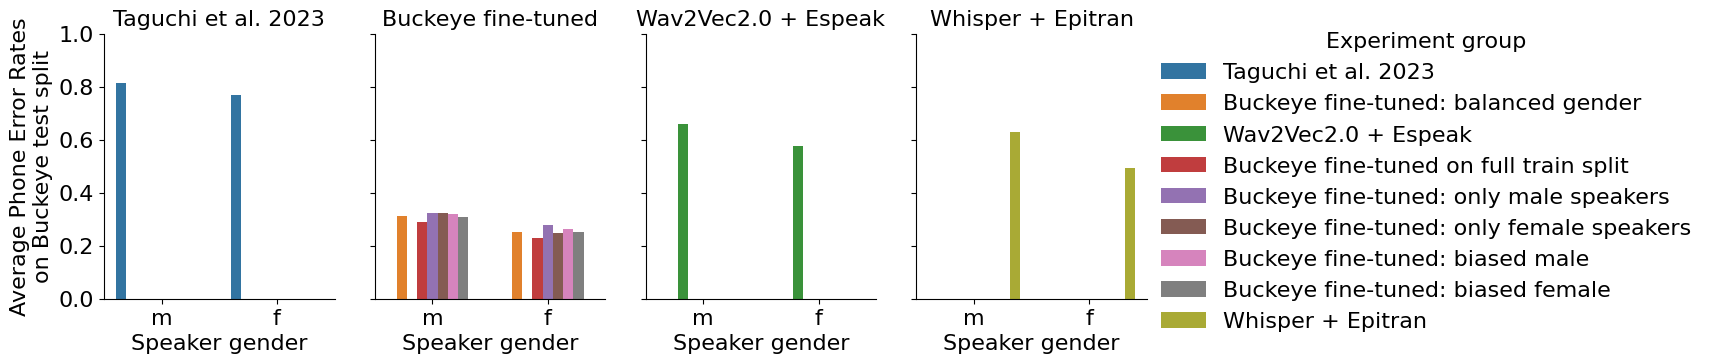

In [18]:
#plt.figure(figsize=(8, 12))
g = sns.catplot(
    best_model_gender_df,
    kind="bar",
    x="speaker_gender",
    y="phone_error_rates",
    hue="Experiment group",
    col="Model source",
    height=4, aspect=0.75
)
g.set(ylim=(0, 1))
g.set_axis_labels("Speaker gender", "Average Phone Error Rates\non Buckeye test split")
g.set_titles("{col_name}")




In [19]:
# Read and join gender duration data
gender_duration_df = pd.read_csv(GENDER_SPLIT_DURATION_CSV)
gender_duration_df["experiment_label"] = gender_duration_df["Experiment script"].apply(lambda x: x[:-3])
gender_duration_df.set_index("experiment_label", inplace=True)

display(gender_duration_df)

,Experiment script,train_duration_female (seconds),train_duration_male (seconds)
experiment_label,,,
data_seed_bs64_1,data_seed_bs64_1.sh,6040.728,5013.809
data_seed_bs64_2,data_seed_bs64_2.sh,5957.211,5211.604
data_seed_bs64_3,data_seed_bs64_3.sh,5634.090,5202.365
data_seed_bs64_4,data_seed_bs64_4.sh,6028.736,4898.312
gender_split_0_female_1,gender_split_0_female_1.sh,0.000,10123.067
gender_split_0_female_2,gender_split_0_female_2.sh,0.000,10130.569
gender_split_0_female_3,gender_split_0_female_3.sh,0.000,10392.944
gender_split_0_female_4,gender_split_0_female_4.sh,0.000,10341.579
gender_split_0_female_5,gender_split_0_female_5.sh,0.000,9938.943


In [20]:
# Order durations and metrics into lists for ease of plotting
gender_duration_dict = gender_duration_df.to_dict("index")
mean_perf_dict = mean_perf_by_gender_df.set_index(["experiment_label", "speaker_gender"]).to_dict("index")

print(gender_duration_dict)
print(mean_perf_dict)


{'data_seed_bs64_1': {'Experiment script': 'data_seed_bs64_1.sh', 'train_duration_female (seconds)': 6040.728, 'train_duration_male (seconds)': 5013.809}, 'data_seed_bs64_2': {'Experiment script': 'data_seed_bs64_2.sh', 'train_duration_female (seconds)': 5957.211, 'train_duration_male (seconds)': 5211.604}, 'data_seed_bs64_3': {'Experiment script': 'data_seed_bs64_3.sh', 'train_duration_female (seconds)': 5634.09, 'train_duration_male (seconds)': 5202.365}, 'data_seed_bs64_4': {'Experiment script': 'data_seed_bs64_4.sh', 'train_duration_female (seconds)': 6028.736, 'train_duration_male (seconds)': 4898.312}, 'gender_split_0_female_1': {'Experiment script': 'gender_split_0_female_1.sh', 'train_duration_female (seconds)': 0.0, 'train_duration_male (seconds)': 10123.067}, 'gender_split_0_female_2': {'Experiment script': 'gender_split_0_female_2.sh', 'train_duration_female (seconds)': 0.0, 'train_duration_male (seconds)': 10130.569}, 'gender_split_0_female_3': {'Experiment script': 'gender

In [21]:
# Combine duration and performance data into lists for easy plotting
label_descriptions = {
    # Models were trained/fine-tuned on 4000 samples unless otherwise noted
    "data_seed_bs64": "Balanced gender",
    "gender_split_0_female": "Only male speakers",
    "gender_split_30_female": "Biased with 70% training samples male",
    "gender_split_70_female": "Biased with 70% training samples female",
    "gender_split_100_female": "Only female speakers",
}
male_metrics = defaultdict(list)
female_metrics = defaultdict(list)
male_train_durations = []
female_train_durations = []
duration_trained_models = []
for exp_id, duration_dict in gender_duration_dict.items():
    print("Processing", exp_id)
    duration_trained_models.append(label_descriptions[exp_id[:-2]])
    male_train_durations.append(duration_dict["train_duration_male (seconds)"])
    female_train_durations.append(duration_dict["train_duration_female (seconds)"])
    for metric_key in ["phone_error_rates", "phone_feature_error_rates"]:
        male_metrics[metric_key].append(mean_perf_dict[(exp_id, "m")][metric_key])
        female_metrics[metric_key].append(mean_perf_dict[(exp_id, "f")][metric_key])

# Check lengths for everything are the same
print("Sanity check: Are all these the same length?")
for d in [male_metrics["phone_error_rates"], female_metrics["phone_error_rates"], male_metrics["phone_feature_error_rates"], female_metrics["phone_feature_error_rates"], male_train_durations, female_train_durations]:
    print(len(d))



Processing data_seed_bs64_1
Processing data_seed_bs64_2
Processing data_seed_bs64_3
Processing data_seed_bs64_4
Processing gender_split_0_female_1
Processing gender_split_0_female_2
Processing gender_split_0_female_3
Processing gender_split_0_female_4
Processing gender_split_0_female_5
Processing gender_split_30_female_1
Processing gender_split_30_female_2
Processing gender_split_30_female_3
Processing gender_split_30_female_4
Processing gender_split_30_female_5
Processing gender_split_70_female_1
Processing gender_split_70_female_2
Processing gender_split_70_female_3
Processing gender_split_70_female_4
Processing gender_split_70_female_5
Processing gender_split_100_female_1
Processing gender_split_100_female_2
Processing gender_split_100_female_3
Processing gender_split_100_female_4
Processing gender_split_100_female_5
Sanity check: Are all these the same length?
24
24
24
24
24
24


In [22]:
def scatter_plot_gender_duration_metric(male_metrics, female_metrics, male_duration, female_duration, title, metric):
    fig, ax = plt.subplots()
    for x, y, color, label in [(male_duration, male_metrics[metric],'tab:blue', "male speaker"),
                                (female_duration, female_metrics[metric], 'tab:orange', "female speaker")]:
        ax.scatter(x, y, c=color, label=label)
    # if metric=="phone_error_rates":
    #     plt.ylim([0,0.4])
    # elif metric=="phone_feature_error_rates":
    #     plt.ylim([0, 6.5])
    plt.ylabel(metric)
    plt.xlabel("Total duration of training samples matching gender (seconds)")
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

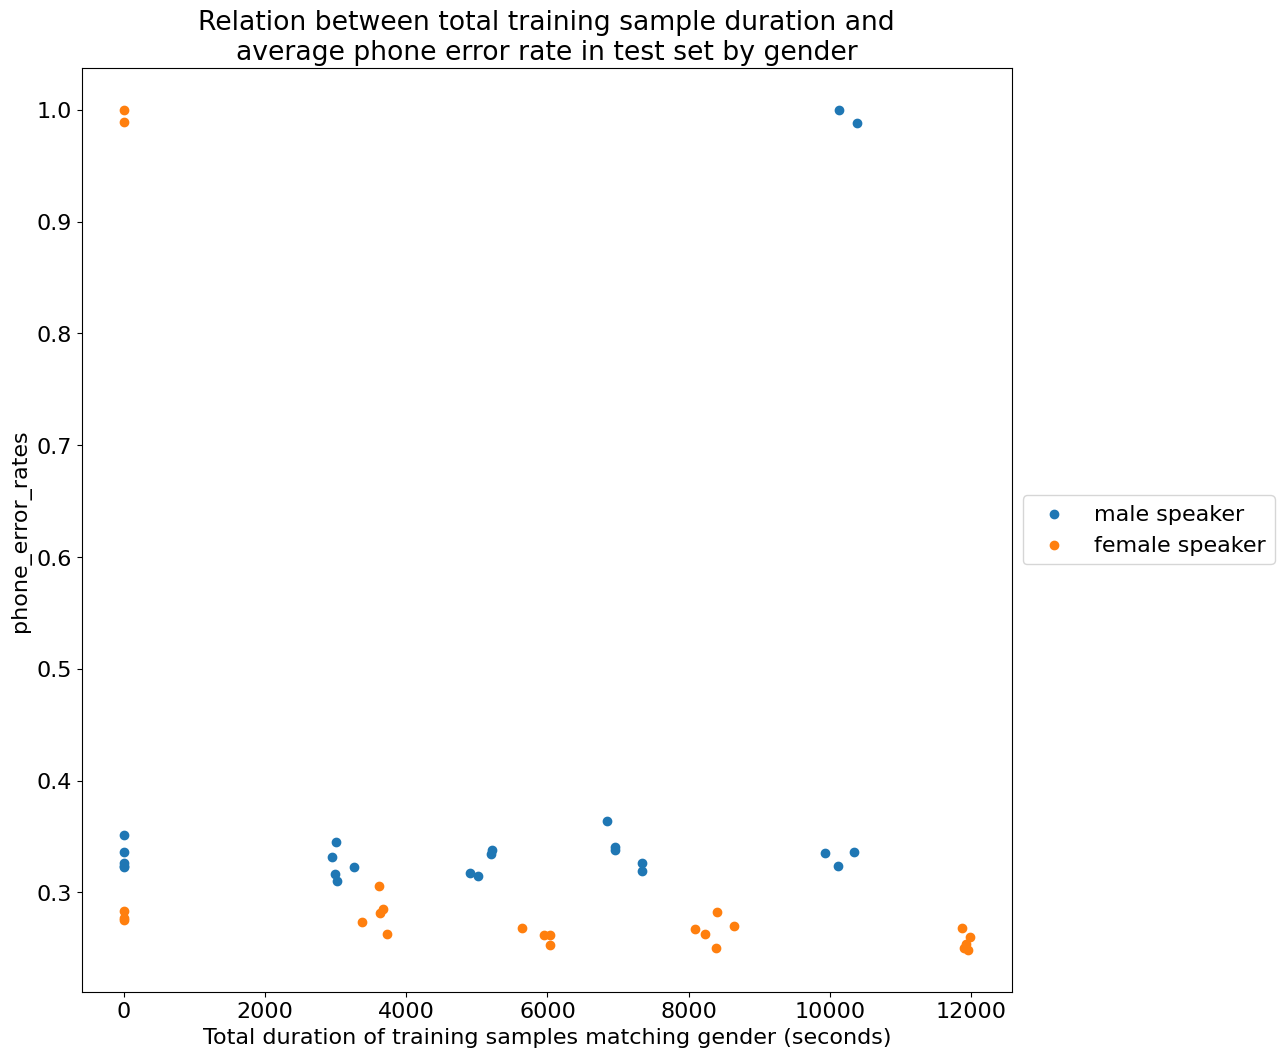

In [23]:
scatter_plot_gender_duration_metric(male_metrics, female_metrics, male_train_durations, female_train_durations,
    "Relation between total training sample duration and\naverage phone error rate in test set by gender", "phone_error_rates")

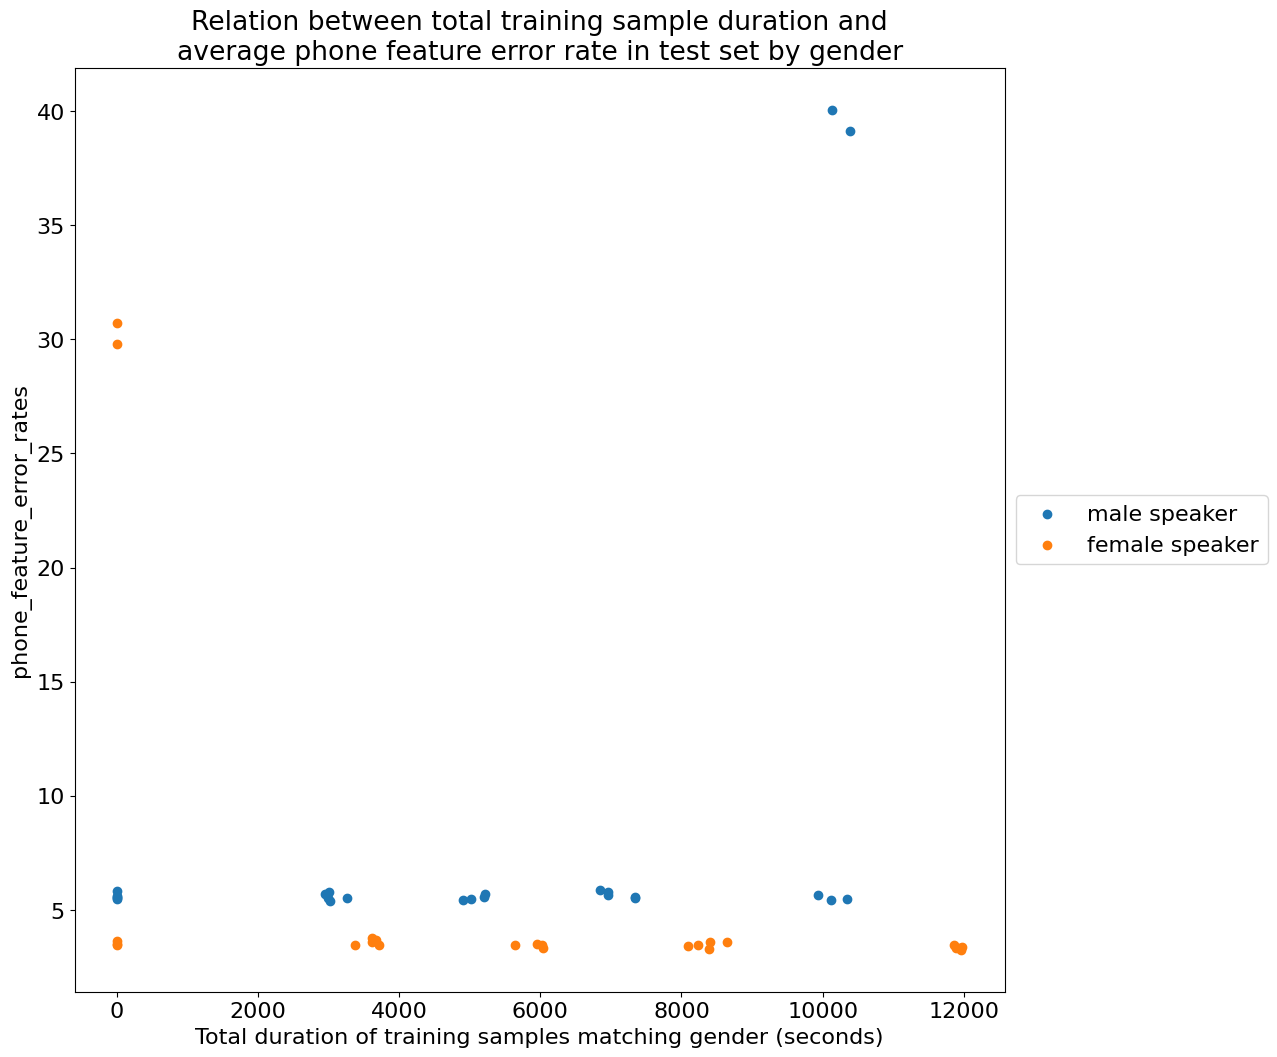

In [24]:
scatter_plot_gender_duration_metric(
    male_metrics,
    female_metrics,
    male_train_durations,
    female_train_durations,
    "Relation between total training sample duration and\naverage phone feature error rate in test set by gender",
    "phone_feature_error_rates",
)

In [25]:
def scatter_plot_model_breakdown(male_metrics, female_metrics, male_duration, female_duration, models, title, metric):
    model_groups = set(models)
    colors = sns.hls_palette(len(model_groups))

    color_map = dict(zip(model_groups, colors))

    fig, ax = plt.subplots(figsize=(8,6), layout="constrained")
    lines_for_legend = []
    labels_for_legend = []
    for i, model in enumerate(models):
        color = color_map[model]
        male_line = ax.scatter(male_duration[i], male_metrics[metric][i], c=color, marker="x", label=model)
        legend_line = ax.scatter(female_duration[i], female_metrics[metric][i], c=color, label=model)
        if model not in labels_for_legend:
            lines_for_legend.append(legend_line)
            labels_for_legend.append(model)

    if metric=="phone_error_rates":
        plt.ylim((0,0.4))
        plt.ylabel("Average Phone Error Rate")
    elif metric=="phone_feature_error_rates":
        plt.ylim((0, 6.5))
        plt.ylabel("Average Phone Feature Error Rate")
    plt.xlabel("Total duration of training samples matching gender (seconds)")
    plt.title(title)
    #plt.xlim((0,12200))
    # Add model groups to legend
    fig.legend(handles=lines_for_legend, bbox_to_anchor=(1.7, 0.5)) #loc='outside right upper')
    # Add gender groups to legend
    fig.legend([male_line, legend_line], ["male speaker", "female speaker"], bbox_to_anchor=(1.34, 0.7)) #loc="outside right center")


/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_71697/1804355906.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  male_line = ax.scatter(male_duration[i], male_metrics[metric][i], c=color, marker="x", label=model)
/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_71697/1804355906.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  legend_line = ax.scatter(female_duration[i], female_metrics[metric][i]

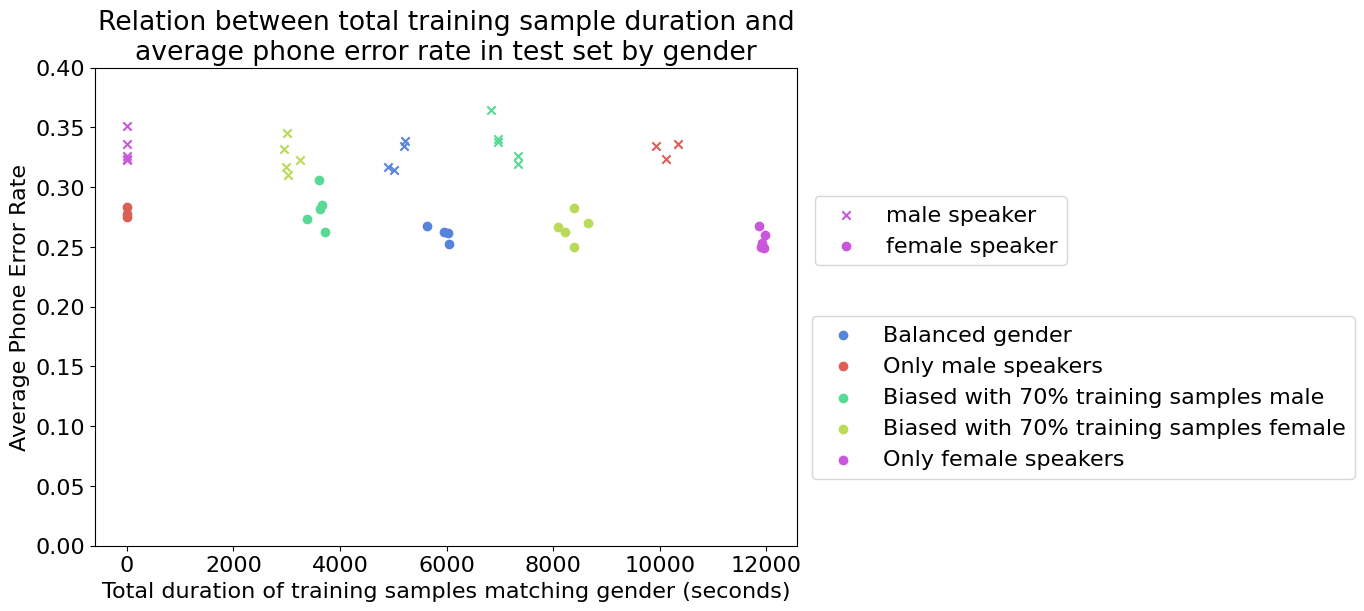

In [26]:
scatter_plot_model_breakdown(male_metrics, female_metrics, male_train_durations, female_train_durations, duration_trained_models,
    "Relation between total training sample duration and\naverage phone error rate in test set by gender", "phone_error_rates")

/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_71697/1804355906.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  male_line = ax.scatter(male_duration[i], male_metrics[metric][i], c=color, marker="x", label=model)
/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_71697/1804355906.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  legend_line = ax.scatter(female_duration[i], female_metrics[metric][i]

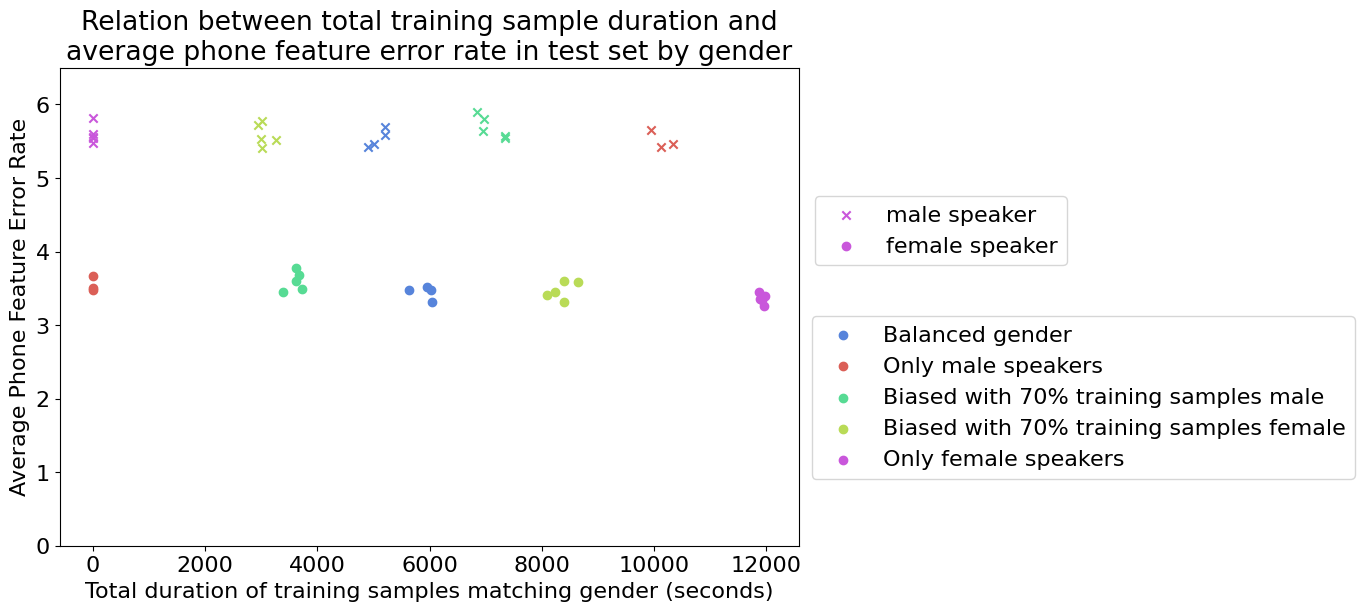

In [27]:
scatter_plot_model_breakdown(
    male_metrics,
    female_metrics,
    male_train_durations,
    female_train_durations,
    duration_trained_models,
    "Relation between total training sample duration and\naverage phone feature error rate in test set by gender",
    "phone_feature_error_rates",
)